### Name: **Gabriel Ohaike**
### Project#1 

#### **Import that Pandas package. We will use to hold the results of the queries, print Pandas tables, and print simple data visualizations.**

In [5]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#### **Before we answer the project questions, Lets take a look at some of the important factors that would help in making an informed decision**

- **Exploring the GoBike dataset reveals that there are a total of 983,648 trips**

In [2]:
! bq query --use_legacy_sql=FALSE 'SELECT count(*) as total_trip FROM `bigquery-public-data.san_francisco.bikeshare_trips`'

Waiting on bqjob_r45c1b7f110c4ae8c_000001727e418cec_1 ... (0s) Current status: DONE   
+------------+
| total_trip |
+------------+
|     983648 |
+------------+


**Are there more customers or subscribers making these trips?**

##### *Further breakdown on the trip showed that out of 983,648 trips, 136,809 which represent 13.9% are customers while 846,839 which represents 86.1% are subscribers*

In [3]:
! bq query --use_legacy_sql=FALSE 'SELECT subscriber_type, COUNT(*) as count FROM `bigquery-public-data.san_francisco.bikeshare_trips` GROUP BY subscriber_type'

Waiting on bqjob_r6f6f3cbf92ab9c95_000001727e4193fd_1 ... (0s) Current status: DONE   
+-----------------+--------+
| subscriber_type | count  |
+-----------------+--------+
| Customer        | 136809 |
| Subscriber      | 846839 |
+-----------------+--------+


### 1) **This brings us to our first project question**

- #### *What are the 5 most popular trips that you would call "commuter trips"?*

- Before we answer this question, let's explore and visualize different types of trips 

In [4]:
%%bigquery all_trip_freq
SELECT start_station_name, end_station_name, count(*) as all_trip_freq 
FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
GROUP BY start_station_name, end_station_name ORDER BY all_trip_freq DESC LIMIT 20

In [5]:
all_trip_freq.head()

,start_station_name,end_station_name,all_trip_freq
0,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,9150
1,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,8508
2,2nd at Townsend,Harry Bridges Plaza (Ferry Building),7620
3,Harry Bridges Plaza (Ferry Building),2nd at Townsend,6888
4,Embarcadero at Sansome,Steuart at Market,6874


#### The trip table above shows all the five most popular trip stattion and the frequency. However, this does not give further information as per if all the trips are commuter trips or not.

- In order to answer this, let extract rush hours to give us an insight as to what type of trips are commuter trip

- Now, lets answer this question:

**What are the most busiest hours of the week?**

In [6]:
%%bigquery busiest_hour
SELECT EXTRACT(HOUR FROM start_date) as Hour, count(EXTRACT(HOUR FROM start_date)) as trip_count_weekday
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE EXTRACT(DAYOFWEEK from start_date) IN (2,3,4,5,6) 
GROUP BY Hour
ORDER BY trip_count_weekday DESC

In [7]:
busiest_hour.head()

,Hour,trip_count_weekday
0,8,128999
1,17,118332
2,9,90264
3,16,79000
4,18,78188


In [8]:
%%bigquery busiest_hour_allday
SELECT EXTRACT(HOUR FROM start_date) as Hour, count(EXTRACT(HOUR FROM start_date)) as trip_count_all
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY Hour
ORDER BY trip_count_all DESC

In [9]:
busiest_hour_allday.head()

,Hour,trip_count_all
0,8,132464
1,17,126302
2,9,96118
3,16,88755
4,18,84569


**The plot below compared the busiest trip time(hours) and counts for 7-day a week vs weekdays(Mon - Friday). Looking at both plots, they seemed to share common rush hours which is somewhere between 6 -10 in the morning and between 16 - 18 in the evening. Therefore, to get a true commuter trips, we need to consider only the trip for weekdays(Mon - Fri) and hours (6-10 & 16-8), this enables us to filter out commuters as chances are that there might be other users who are not commuters for example. GoBike technicians and maintenance team etc.**

<Figure size 864x648 with 0 Axes>

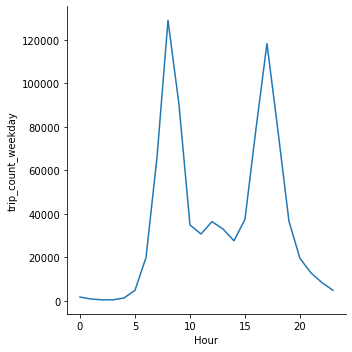

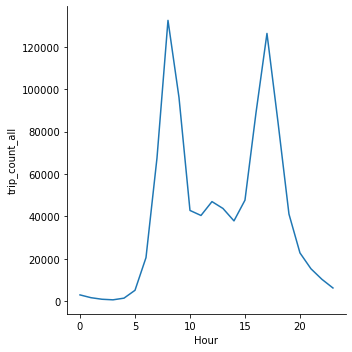

In [10]:
plt.figure(figsize=(12,9)) 
sns.relplot(x='Hour',y='trip_count_weekday',data=busiest_hour, kind="line")
sns.relplot(x='Hour',y='trip_count_all',data=busiest_hour_allday, kind="line")
pass

#### Finally, this led us into 5 most popular trips to identify commuter trips below. Obviously, high surge in rush hour like 8,9,16,17,18 is an evidence that those are commuters.

In [11]:
%%bigquery commuter_trip
SELECT count(trip_id) as trip_freq ,start_station_name, end_station_name,CONCAT(start_station_name, ' ','to', ' ',end_station_name) as trip  
FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
WHERE EXTRACT(DAYOFWEEK from start_date) IN (2,3,4,5,6) AND EXTRACT(HOUR from start_date) IN (6,7,8,9,10,16,17,18,19)
GROUP BY start_station_name, end_station_name ORDER BY trip_freq DESC LIMIT 5

In [12]:
commuter_trip

,trip_freq,start_station_name,end_station_name,trip
0,6352,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,San Francisco Caltrain 2 (330 Townsend) to Tow...
1,5647,Harry Bridges Plaza (Ferry Building),2nd at Townsend,Harry Bridges Plaza (Ferry Building) to 2nd at...
2,5454,2nd at Townsend,Harry Bridges Plaza (Ferry Building),2nd at Townsend to Harry Bridges Plaza (Ferry ...
3,5218,Embarcadero at Sansome,Steuart at Market,Embarcadero at Sansome to Steuart at Market
4,5192,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),San Francisco Caltrain (Townsend at 4th) to Ha...


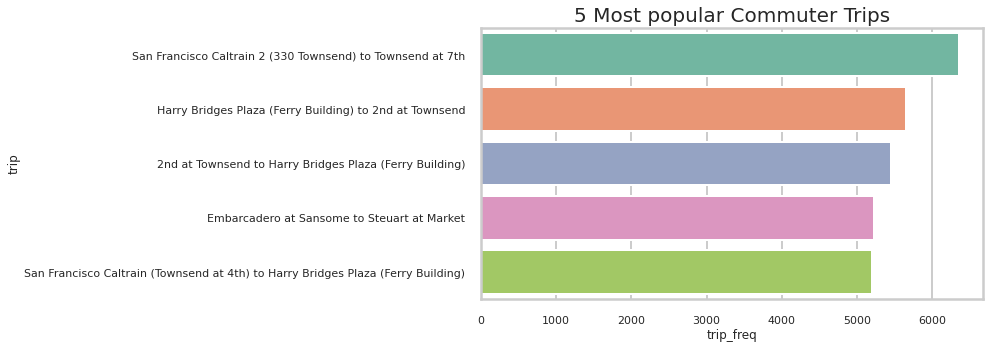

In [13]:
plt.figure(figsize=(9,5)) 
sns.set_context('poster',font_scale=0.5)
sns.set_style('whitegrid')
plt.title('5 Most popular Commuter Trips',fontsize =20)
sns.barplot(x="trip_freq", y="trip", data=commuter_trip, palette=sns.color_palette("Set2"))
pass

### **Second project Question**

### **What are your recommendations for offers (justify based on your findings)?**

**Before we make recommendations. let's look at the current [GoBike Pricing]('https://www.lyft.com/bikes/bay-wheels/pricing')**


### **Summary of GoBike current offering:**

- Annual Membership: 149.00 per annum. Free for the first 45 mins ride and 3.00 per 15 mins after
        
-  Monthly Membership:15.00 per month. Free for the first 45 mins ride and 3.00 per 15 mins after
        
- Single Ride: 2.00 for the first 30 mins and 3.00 per 15 mins after.
        
- Access Pass: 10.00 per day for the first 30 ride and 3.00 per 15 mins after.(but you bike station by station to save cost)
    
- Ebiking: Members pay 0.15/minute
  - Non-members pay 0.20/minute
  - Bike Share for All Members pay 0.05/minute with a cap of 1
  - Dock at any Bay Wheels station for free or use the cable to lock to a bike rack within the service area for 2. 
  - This charge will be waived if you park near a station that has no empty docks or park in part of the service area without stations. 
  - Always lock responsibly.This new pricing applies to ebike rides in San Francisco

### **We begin by filtering the commutes that are within 30 mins** 

**From the GoBike current offering summary, we able to identify different types of subscribers types. This also help in determining most importnat time which is less/greater than 30 mins, less/greater than 45 mins, we this in mind, let us proceeed with some data analysis**

#### **First, lets filter all time between 5mins to 60 mins**

In [14]:
%%bigquery trip_hr_5_60

SELECT EXTRACT(HOUR FROM start_date) AS HR_of_day, duration_sec,(duration_sec/60) as duration_5mins_60mins,start_station_name,end_station_name,subscriber_type
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE ((duration_sec/60) >= 5 AND (duration_sec/60) <= 60)
ORDER BY (duration_sec/60) DESC

In [15]:
trip_hr_5_60.head()

,HR_of_day,duration_sec,duration_5mins_60mins,start_station_name,end_station_name,subscriber_type
0,12,3600,60.0,Embarcadero at Sansome,2nd at South Park,Customer
1,13,3600,60.0,Steuart at Market,Steuart at Market,Customer
2,15,3600,60.0,Mechanics Plaza (Market at Battery),Embarcadero at Vallejo,Customer
3,16,3600,60.0,2nd at Townsend,Grant Avenue at Columbus Avenue,Customer
4,9,3600,60.0,San Francisco Caltrain (Townsend at 4th),Mechanics Plaza (Market at Battery),Subscriber


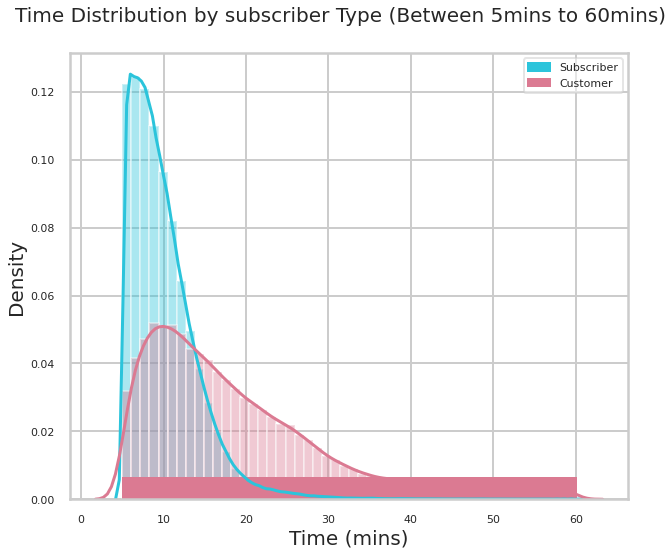

In [16]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle("Time Distribution by subscriber Type (Between 5mins to 60mins)",fontsize= 20)
fig.subplots_adjust(top=0.9)

sns.distplot(trip_hr_5_60.loc[trip_hr_5_60.subscriber_type=="Subscriber", "duration_5mins_60mins"], 
             norm_hist=True, color="#2bc4db", rug=True, bins=50)
sns.distplot(trip_hr_5_60.loc[trip_hr_5_60.subscriber_type=="Customer", "duration_5mins_60mins"], 
             norm_hist=True, color="#db7a92", rug=True, bins=50)

ax.set_ylabel("Density", fontsize=20)
ax.set_xlabel("Time (mins)", fontsize=20)

green_patch = matplotlib.patches.Patch(color="#2bc4db", label="Subscriber")
red_patch = matplotlib.patches.Patch(color="#db7a92", label="Customer")
ax.legend(handles=[green_patch, red_patch], facecolor="white", edgecolor="#cccccc", framealpha=0.5, fancybox=True)
pass

**The fig above is a plot of trip duration time in mins. The time was taking from duration_sec from GoBike trips datasets. Here, we decided to take a look at trip range between 5mins - 60mins and compared to subscriber types.**

## Findings
### **Here are some of the findings from the plots**.

 * You can see that most of the trips by subscribers averages around 10 -15 mins, on the high side, it barely get to 25mins of trip time. Why then do we offer 45mins?
 * On the other hand, the customer subscriber type averages 15 -20 mins and showed mores above 30 mins. This subscriber type showed more signs of longer trips is their offer is,nt restricted to 30 mins.Why then do we offer them less trip offering?

### In further analysis, let's take a closer look at the count above 30 mins and 45 mins respectively

In [17]:
! bq query --use_legacy_sql=FALSE 'SELECT subscriber_type , COUNT(*) as freq FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE (duration_sec/60) >= 30 GROUP BY subscriber_type'

Waiting on bqjob_r643f97ea58369790_000001727e4285dc_1 ... (0s) Current status: DONE   
+-----------------+-------+
| subscriber_type | freq  |
+-----------------+-------+
| Customer        | 42032 |
| Subscriber      |  5336 |
+-----------------+-------+


### **As compared to the total trip count of subscriber type in the GoBike trips dataset**

In [18]:
! bq query --use_legacy_sql=FALSE 'SELECT subscriber_type , COUNT(*)as freq FROM `bigquery-public-data.san_francisco.bikeshare_trips` GROUP BY subscriber_type'

Waiting on bqjob_r2f9b1a2e20131385_000001727e428b80_1 ... (0s) Current status: DONE   
+-----------------+--------+
| subscriber_type |  freq  |
+-----------------+--------+
| Customer        | 136809 |
| Subscriber      | 846839 |
+-----------------+--------+


- **From the two table above. Recall that there are 86.1% of subscribers as compared to 13.9% of customer in the GoBike Trips dataset. For trips of 30 mins or above, 89% are customer while 11% are subscriber**

### **Let us go further for trips of 45 mins and above** 

In [19]:
! bq query --use_legacy_sql=FALSE 'SELECT subscriber_type , COUNT(*) as freq FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE (duration_sec/60) >= 45 GROUP BY subscriber_type'

Waiting on bqjob_r6d0d7eb4f331a0e_000001727e4291d7_1 ... (0s) Current status: DONE   
+-----------------+-------+
| subscriber_type | freq  |
+-----------------+-------+
| Customer        | 31511 |
| Subscriber      |  2926 |
+-----------------+-------+


- **Again comparing trips of 45mins and above, 92% are customers while 8% are subscribers**

### Now let's get some insight about how to improve our present offering by looking at 

- The busiest stations

- Dock count


In [20]:
%%bigquery station_count
SELECT  start_station_id, COUNT(*) as freq FROM `bigquery-public-data.san_francisco.bikeshare_trips`GROUP BY start_station_id ORDER BY 2

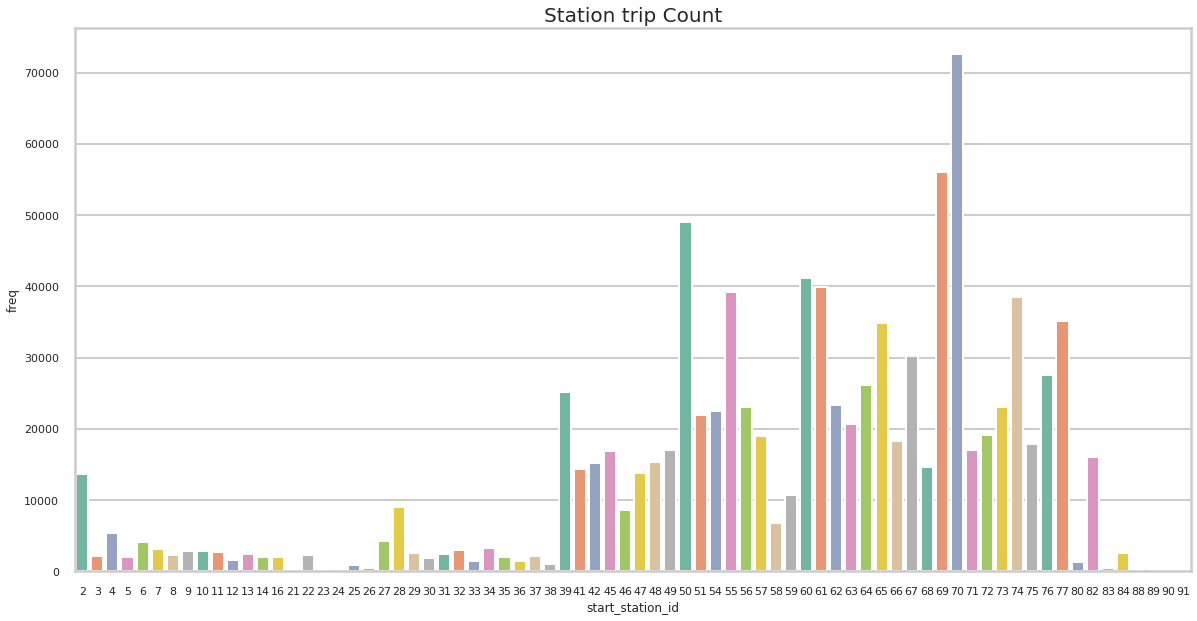

In [21]:
plt.figure(figsize=(20,10)) 
sns.set_context('poster',font_scale=0.5)
sns.set_style('whitegrid')
plt.title('Station trip Count',fontsize =20)
sns.barplot(x="start_station_id", y="freq", data=station_count, palette=sns.color_palette("Set2"))
pass

### Filtering out top 10 busiest stations

In [22]:
station_count.sort_values(['freq'], ascending=[False]).head(10)

,start_station_id,freq
73,70,72683
72,69,56100
71,50,49062
70,60,41137
69,61,39936
68,55,39200
67,74,38531
66,77,35142
65,65,34894
64,67,30209


### The figure above show the busiest station

In [23]:
%%bigquery dockcount
SELECT station_id, name, dockcount, FROM `bigquery-public-data.san_francisco.bikeshare_stations` 

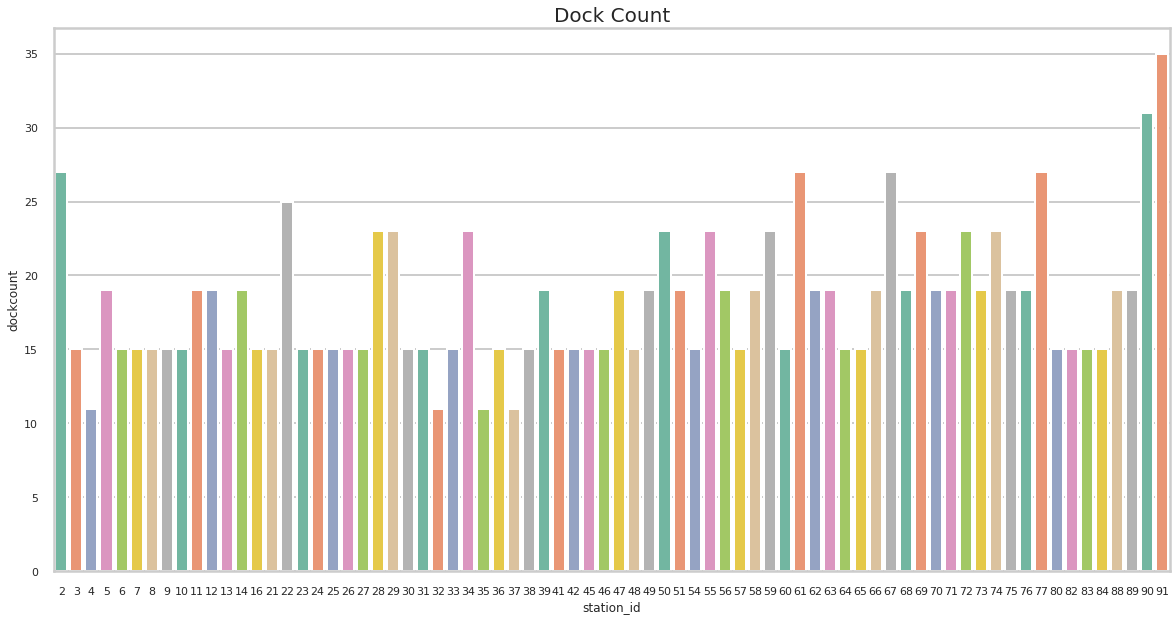

In [24]:
plt.figure(figsize=(20,10)) 
sns.set_context('poster',font_scale=0.5)
sns.set_style('whitegrid')
plt.title('Dock Count',fontsize =20)
sns.barplot(x='station_id', y="dockcount", data=dockcount,palette=sns.color_palette("Set2"))
pass

In [25]:
%%bigquery dockcount
SELECT station_id, name, dockcount, FROM `bigquery-public-data.san_francisco.bikeshare_stations` 

In [26]:
dockcount.sort_values(['dockcount'], ascending=[False]).head(10)

,station_id,name,dockcount
73,91,Cyril Magnin St at Ellis St,35
72,90,5th St at Folsom St,31
71,77,Market at Sansome,27
70,67,Market at 10th,27
69,61,2nd at Townsend,27
68,2,San Jose Diridon Caltrain Station,27
67,22,Redwood City Caltrain Station,25
61,50,Harry Bridges Plaza (Ferry Building),23
58,34,Palo Alto Caltrain Station,23
59,29,San Antonio Caltrain Station,23


In [ ]:
%%bigquery trip_status

SELECT station_id,bikes_available,docks_available,EXTRACT(Hour from time) as HR_of_day FROM `bigquery-public-data.san_francisco.bikeshare_status` 
ORDER BY station_id

In [ ]:
trip_status.tail()

In [ ]:
g = sns.FacetGrid(trip_status, col="time")
g.map(plt.hist, "tip");

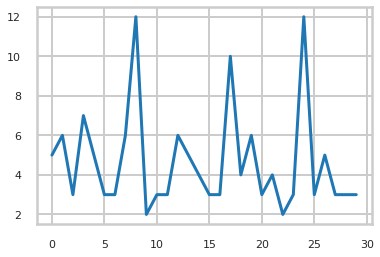

In [51]:
trip_status["bikes_available"].plot()

ValueError: Could not interpret input 'HR_of_day'

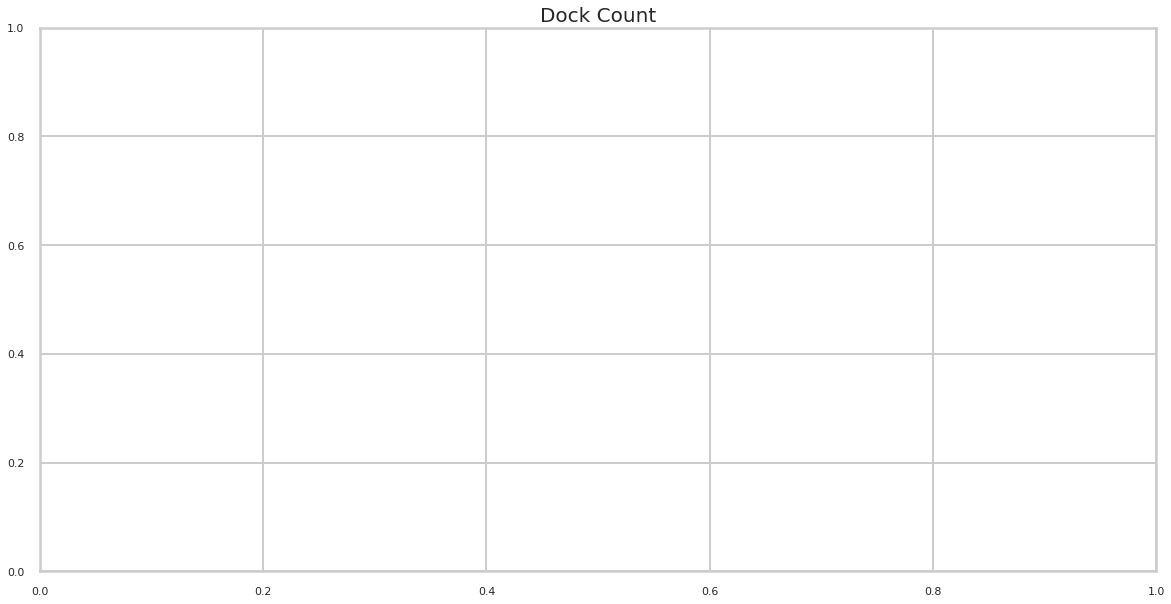

In [10]:
plt.figure(figsize=(20,10)) 
sns.set_context('poster',font_scale=0.5)
sns.set_style('whitegrid')
plt.title('Dock Count',fontsize =20)
sns.barplot(x='HR_of_day', y="dock_available", data=trip_status,palette=sns.color_palette("Set2"))

In [46]:
trip_status.plot(x="docks_available", y=["station_id","docks_available"], kind="bar")

KeyError: "['docks_available'] not in index"

In [ ]:
ax = plt.gca()

trip_status.plot(kind='line',x='bikes_available',y='station_id',ax=ax)
trip_status.plot(kind='line',x='docks_available',y='station_id', color='red', ax=ax)

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,15))
fig.suptitle("Number of Climbers (1905-2019)", 
             fontsize=20)
fig.subplots_adjust(top=0.9)

sns.lineplot(x=trip_status["station_id"], y="bikes_available",ax=ax, data=trip_status, markers=True, dashes=False, color="blue")
sns.lineplot(x=trip_status["station_id"], y="docks_available", ax=ax, data=trip_status,markers=True, dashes=False, color="green")
ax.set_xlabel("Station_id", fontsize=20)
ax.set_ylabel(" Docks and Bikes available", fontsize=20)

blue_patch = matplotlib.patches.Patch(color="blue", label="bikes_available")
green_patch = matplotlib.patches.Patch(color="green", label="docks_available")
ax.legend(handles=[blue_patch, green_patch], facecolor="white", edgecolor="#cccccc", framealpha=0.5, fancybox=True)

pass